In [ ]:
"""

Arvo Pärt - Fratres

This example showcases the following arvo modules:

minimalism for creating the additive process
transformations for scalar transposition and inversion
tintinnabuli for generating the tintinabuli

The python script also contains many standard music21 functions to construct the entire piano part
including the pedal point and the 2-bar interludes between the melodic sections. It is thus a bit
longer, but I wanted to reproduce the piano part as closely as possible.

The generated piece differs very slightly from Arvo Pärt's manuscript in a few instances, notably
the tininnabuli line. Indeed, even if the vast majority of the t-voice is strictly in second
osition below the melody, Pärt "cheats" in a few places to create a better sonority or for reasons
of musical direction.

"""

import copy
from music21 import meter
from music21 import stream
from music21 import scale
from music21 import metadata
from music21 import clef
from music21 import chord
from music21 import duration
from music21 import layout
from music21 import note
from music21 import spanner
from arvo import isorhythm
from arvo import minimalism
from arvo import tintinnabuli
from arvo import tools
from arvo import transformations

In [ ]:
# ------------------------------------------------------------------------------
# Define basic elements
# ------------------------------------------------------------------------------

# Set reference scale (A Major Phrygian) for inversion/transposition operations
reference_scale = scale.ConcreteScale(
    pitches=["A4", "B-4", "C#5", "D5", "E5", "F5", "G5"]
)

# Define t-chord (A minor) for the tintinnabuli process
t_chord = ["A", "C", "E"]

# Define a list of quarter note offsets for adding left-hand pedal notes
bar_offsets = [0, 7, 16, 27, 34, 43, 54]

# Build core scale pattern
scale_pattern = isorhythm.create_isorhythm(
    reference_scale.getPitches("C#6", "G5") + reference_scale.getPitches("F6", "C#6"),
    [2, 1, 1, 1, 1, 1, 1, 3],
)

In [ ]:
# --------------------------------------------------------------------------------------------------
# Build the core melody for one section
# --------------------------------------------------------------------------------------------------
# Create additive process
core_melody = minimalism.additive_process(
    scale_pattern, direction=minimalism.Direction.INWARD, iterations_start=2
)

# Add time signatures
core_melody.insert(0, meter.TimeSignature("7/4"))
core_melody.insert(7, meter.TimeSignature("9/4"))
core_melody.insert(16, meter.TimeSignature("11/4"))

# Append inverted version for the second half
tools.append_stream(
    core_melody, transformations.scalar_inversion(core_melody, "C#6", reference_scale)
)

In [ ]:
# --------------------------------------------------------------------------------------------------
# Define function to add two bars interlude (this uses only normal music21 elements)
# --------------------------------------------------------------------------------------------------

# Right hand
def _right_hand_interlude():
    rh_interlude = stream.Stream()
    rh_interlude.append(meter.TimeSignature("6/4"))
    rh_interlude.append(clef.BassClef())
    rh_interlude.repeatAppend(
        chord.Chord(["A1", "E2", "A2"], duration=duration.Duration(6)), 2
    )
    rh_interlude.makeMeasures(inPlace=True, finalBarline=None)
    return rh_interlude

In [ ]:
# Left hand
def _left_hand_interlude():
    lh_interlude = stream.Voice()
    lh_interlude.append(meter.TimeSignature("6/4"))
    for _ in range(2):
        lh_interlude.append(note.Rest(duration=duration.Duration(2.75)))
        note_1 = note.Note("E1", duration=duration.Duration(0.25))
        note_2 = note.Note("A0", duration=duration.Duration(3))
        ottava = spanner.Ottava()
        ottava.type = (8, "down")
        ottava.addSpannedElements([note_1, note_2])
        lh_interlude.append(ottava)
        lh_interlude.append(note_1)
        lh_interlude.append(note_2)
        lh_interlude.makeMeasures(inPlace=True, finalBarline=None)
    return lh_interlude

In [ ]:
# --------------------------------------------------------------------------------------------------
# Build the piece
# --------------------------------------------------------------------------------------------------
# Create streams
right_hand = stream.Part()
left_hand = stream.Part()

left_hand.clef = clef.TrebleClef()

# Main Loop to build the nine sections
for section_index in range(8):
    # Right hand
    # -----------------------------------------------------------------------------------------
    # Create the m-voice
    m_voice = transformations.scalar_transposition(
        core_melody, section_index * -2, reference_scale
    )

    # Create the t-voice
    t_voice = tintinnabuli.create_t_voice(
        m_voice, t_chord, position=2, direction=tintinnabuli.Direction.DOWN
    )

    # Merge and append right hand streams
    tools.append_stream(right_hand, tools.merge_streams(m_voice, t_voice).chordify())

    # Append right hand interlude
    tools.append_stream(right_hand, _right_hand_interlude())
    if section_index < 6:
        right_hand.append(clef.TrebleClef())  # Add treble clef except for last section

    # Left hand
    # ----------------------------------------------------------------------------------------------
    # Create the second m-voice
    m_voice2 = transformations.scalar_transposition(m_voice, -9, reference_scale)

    # Create the pedal
    bottom_pedal = stream.Voice()
    top_pedal = stream.Stream()

    for i in range(6):
        # Define notes to use depending on the section
        if section_index in (0, 2):
            bottom_pedal_note = chord.Chord(["A3", "E4"])
        elif section_index in (1, 3):
            bottom_pedal_note = note.Note("A3")
            top_pedal_note = note.Note("E4")
        elif 3 < section_index < 7:
            bottom_pedal_note = note.Note("A2")
            top_pedal_note = note.Note("E3")
        else:
            bottom_pedal_note = note.Note("A2")

        # Insert bottom pedal note in separate lower voice
        bottom_pedal.insert(bar_offsets[i], bottom_pedal_note)
        bottom_pedal_note.duration = duration.Duration(
            bar_offsets[i + 1] - bar_offsets[i]
        )

        # Insert top pedal note in m-voice chords
        if section_index not in (0, 2, 7):
            top_pedal_note2 = copy.deepcopy(top_pedal_note)
            top_pedal.insert(bar_offsets[i], top_pedal_note)
            top_pedal_note.duration = duration.Duration(2)
            top_pedal.insert(bar_offsets[i + 1] - 3, top_pedal_note2)
            top_pedal_note2.duration = duration.Duration(3)
            m_voice2 = tools.merge_streams(m_voice2, top_pedal).chordify()

    # Merge and append left hand streams
    if section_index != 2:
        lh = tools.merge_streams(
            tools.convert_stream(m_voice2, stream.Voice), bottom_pedal
        )
        lh.makeMeasures(inPlace=True, finalBarline=None)
    else:
        lh = tools.merge_streams(m_voice2, bottom_pedal).chordify(addTies=False)
        lh.makeMeasures(inPlace=True, finalBarline=None)
    tools.append_stream(left_hand, lh)

    # Append left hand interlude
    if section_index < 3:
        left_hand.append(clef.BassClef())
    tools.append_stream(left_hand, _left_hand_interlude())
    if section_index < 2:
        left_hand.append(clef.TrebleClef())

In [ ]:
# --------------------------------------------------------------------------------------------------
# Build final score
# --------------------------------------------------------------------------------------------------

right_hand.makeMeasures(inPlace=True)
score = tools.merge_streams(right_hand, left_hand, stream_class=stream.Score)
piano_staff_group = layout.StaffGroup(
    [right_hand, left_hand], name="Piano", abbreviation="Pno.", symbol="brace"
)
score.insert(0, piano_staff_group)
score.metadata = metadata.Metadata()
score.metadata.title = "Fratres (Piano Part)"
score.metadata.composer = "Arvo Pärt"

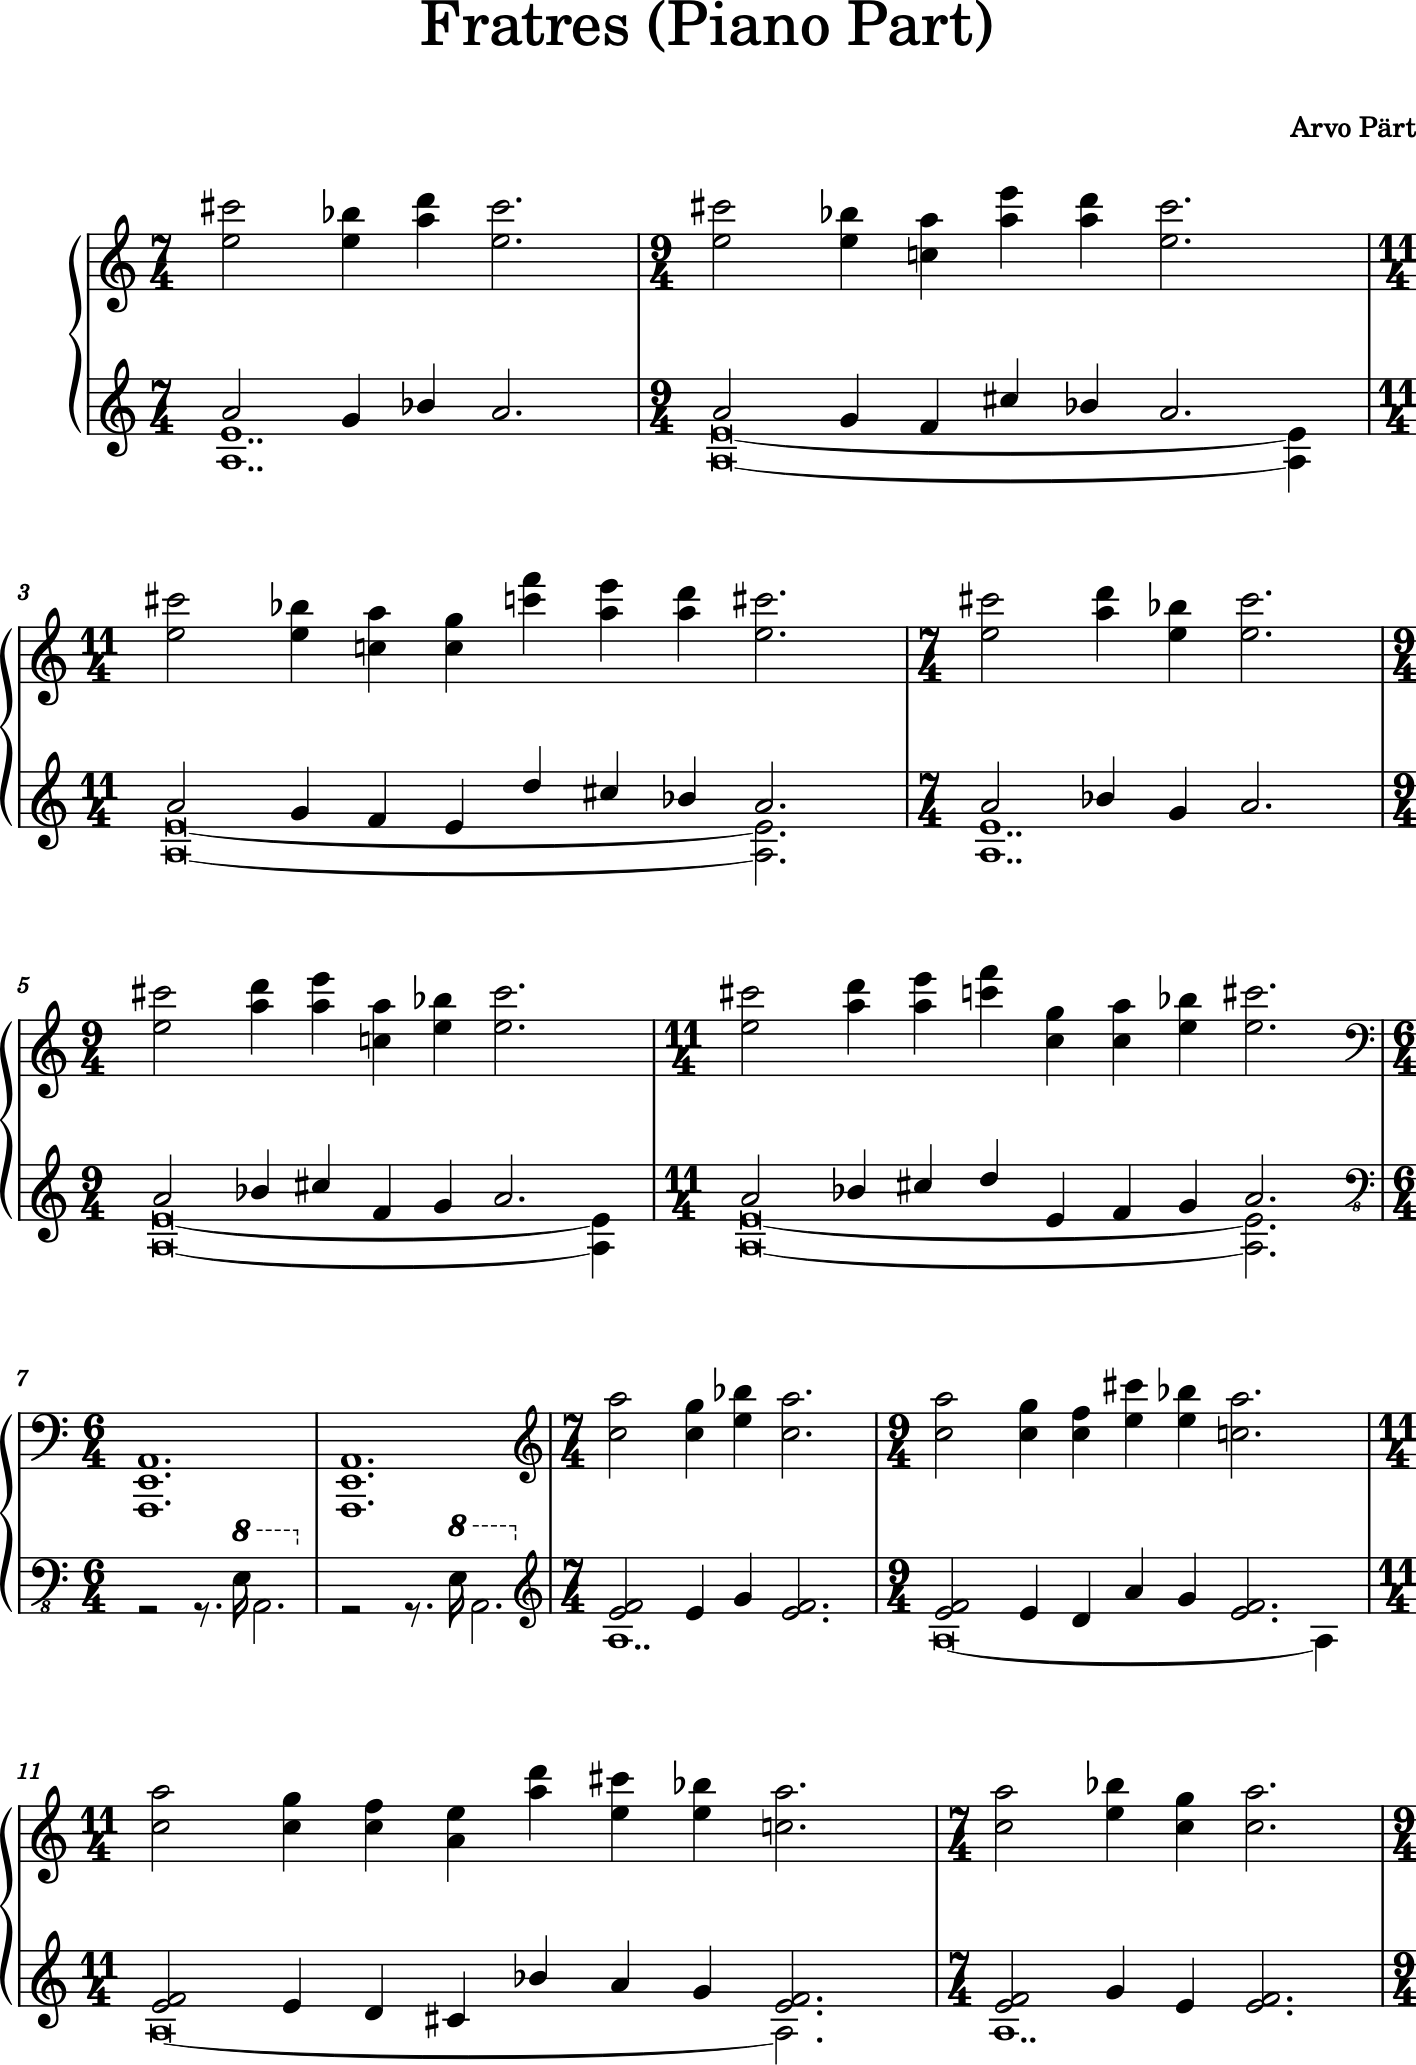

In [1]:
# --------------------------------------------------------------------------------------------------
# Output midi file and show score in MuseScore
# --------------------------------------------------------------------------------------------------
score.write('midi', fp="arvo_part_fratres.mid")
score.show()